## This code estimates the secondary water flow rate.

In [1]:
import os
from numpy import *
from H_utility import *
from pandas import *
from Data_Unzip import *
currentfolder='/home/adun6414/Work/CERC_UCM'

os.chdir('/home/adun6414/Work/CERC_UCM/unzipped_RawData')
filename=os.listdir(os.getcwd())   
data=dict()
for k in filename:
    if '.csv' in k:
        name=k.split('.')[0]
        data[name]=read_csv(k).set_index('Date')
        data[name]=data[name].set_index(to_datetime(data[name].index))
os.chdir(currentfolder)

<Figure size 720x360 with 0 Axes>

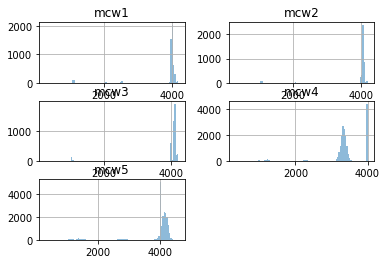

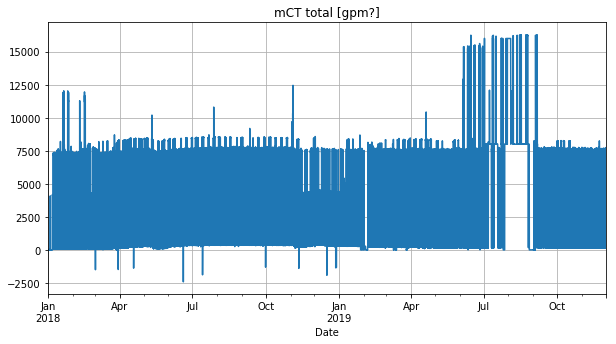

In [2]:
wannasave=False
#%% condensor water flow rate is constantly controlled.
startdate='2018-01-01 00:00'#'2018-08-01 00:00'
enddate='2019-11-30 23:50'#'2018-08-06 23:45'#'2019-08-3'
dates=date_range(start=startdate,end=enddate,freq='15T')
DATA=DataFrame(index=dates)
DATA.index.name='Date'
# close('all')

mCW=data['mCW'][startdate:enddate].resample('15T').mean().apply(gpm2kgs) # gpm???
mCW.columns=['mcw1','mcw2','mcw3','mcw4','mcw5']

figure(figsize=(10,5))
mCW[mCW>gpm2kgs(300)].apply(kgs2gpm).hist(bins=100,alpha=0.5)
title('CW [gpm?]')
if wannasave:
    savefig('mCWpgm.png')
mCWscale=mCW/mCW.dropna().max()
mCW['mcwsum']=mCW.sum(axis=1)

figure(figsize=(10,5))
mCW['mcwsum'].apply(kgs2gpm).plot(grid=True)
title('mCT total [gpm?]')
if wannasave:
    savefig('mCT_tot_gpm.png')

DATA=DATA.merge(mCW,how='outer',on='Date') # append data


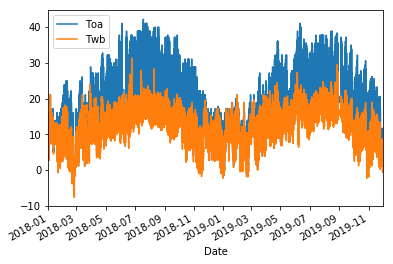

In [3]:
#%% weather data
#Toa=data['Toa'][startdate:enddate].resample('15T').mean()
Toa=data['Toa'][startdate:enddate].reindex(dates,method='nearest')

#RH=data['RH'][startdate:enddate].resample('15T').mean()
RH=data['RH'][startdate:enddate]
RH=RH[~RH.index.duplicated()]
RH=RH.reindex(dates,method='nearest')

Weather=Toa.merge(RH,on='Date',how='inner')
Weather.columns=['Toa','RH']
Weather=Weather.dropna()
from  H_Psychrometric import *
Twb = TwTRH(Weather.iloc[:,0].to_numpy()+273.15,Weather.iloc[:,1].to_numpy()) #HumRat(AirH2O,T=T_a_in , P=p_atm,B=T_wb_in ) "lbm/lbm"                "Humidity ratio"
Weather['Twb']=k2c(Twb)
#for k in range(Weather.shape[0]):
#    try:
#        Twb = HAPropsSI('B','T',Weather.iloc[k,0].to_numpy()+273.15,'R',Weather.iloc[k,1].to_numpy()*1./100,'P',101325) #HumRat(AirH2O,T=T_a_in , P=p_atm,B=T_wb_in ) "lbm/lbm"                "Humidity ratio"
#    except:
#        Twb = np.NaN

Weather.plot(y=['Toa','Twb'])
DATA=DATA.merge(Weather,how='outer',on='Date')

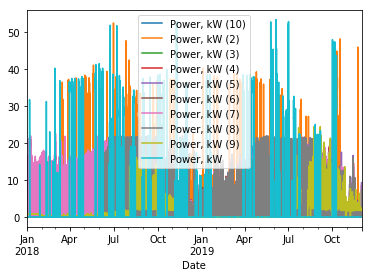

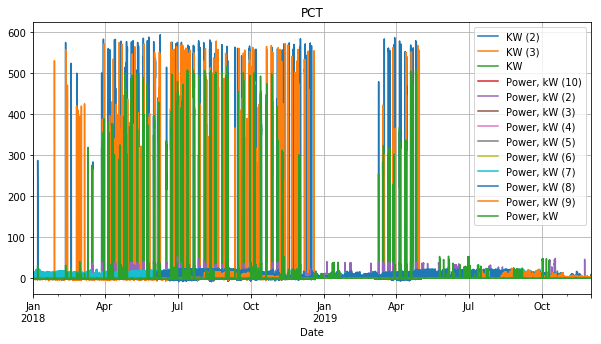

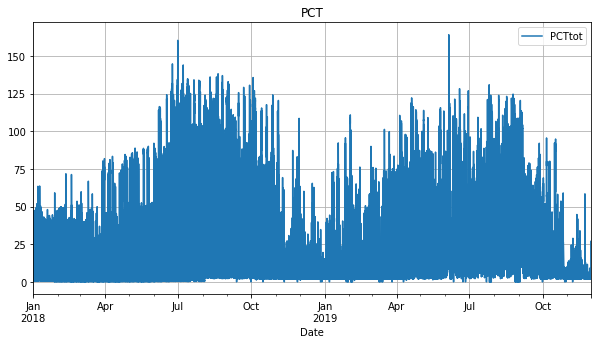

In [4]:
#%% Cooling Tower Power, What is kW (1), kW(2), kW(3) ????
PCT=data['PCT'][startdate:enddate].resample('15T').mean()
PCT[[k for k in PCT.columns.to_list() if 'Power' in k]].plot()
PCTtot=PCT[[k for k in PCT.columns.to_list() if 'Power' in k]].sum(axis=1).to_frame('PCTtot')

figure(figsize=(10,5))
ax=subplot(111)
PCT.plot(ax=ax,grid=True)
title('PCT')

figure(figsize=(10,5))
ax=subplot(111)
PCTtot.plot(ax=ax,grid=True)
title('PCT')
if wannasave:
    savefig('PCT_total_kW.png')
    
DATA=DATA.merge(PCTtot,how='outer',on='Date')

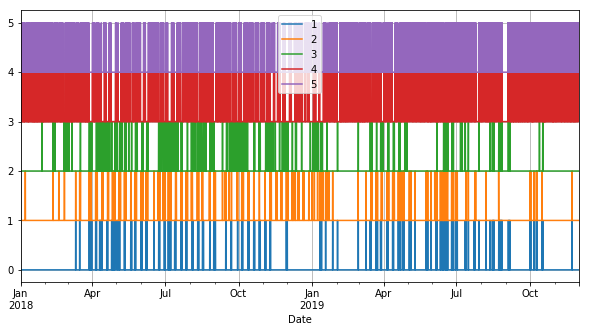

In [5]:
#%% check it is exactly correlated with chiller operation
PCH=data['PCH_kW'][startdate:enddate].resample('15T').mean()
PCH['PCHsum']=PCH.sum(axis=1)
#PCH[PCH>0].iloc[:,0:5].plot.hist(bins=30,alpha=0.5)
# 1. whenever 4 is activated, 5 is activated and none of 1,2,3 are activated.
ON=DataFrame()
ONPLOT=DataFrame()
mCWPLOT=DataFrame()
for i in range(1,6):
    ON[str(i)]=1*(PCH[enum('P',i)]>10)
    ONPLOT[str(i)]=1*(PCH[enum('P',i)]>10)+i-1
#    mCWPLOT[str(i)]=mCWscale[str(i)]+i-1

figure(figsize=(10,5))
ax=subplot(111)
ONPLOT.plot(ax=ax,grid=True)
#if wannasave:
#    savefig('data_mCW_PCHON.png')

DATA=DATA.merge(PCH,how='outer',on='Date')

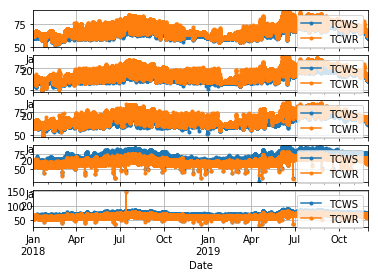

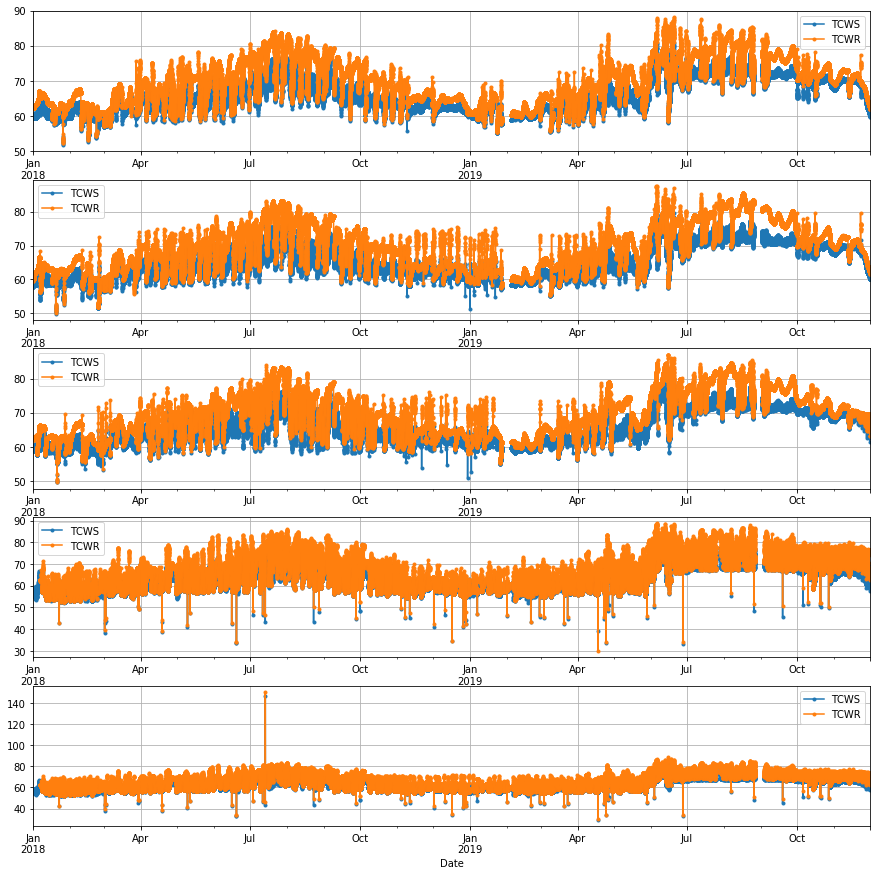

In [6]:
#%% TCW, 1,2,3 are named correctly but 4,5 are opposite
TCWS=data['TCWS'][startdate:enddate].resample('15T').mean()
TCWR=data['TCWR'][startdate:enddate].resample('15T').mean()


figure()
for i in range(1,6):
    ax=subplot(5,1,i)
    TCWS[enum('TCWS',i)].plot(ax=ax,style='.-')
    TCWR[enum('TCWR',i)].plot(ax=ax,style='.-')
    legend(['TCWS','TCWR'])
    grid(True)

#% rename data
TCW=TCWS.merge(TCWR,on='Date')
TCWS=DataFrame()
TCWR=DataFrame()

for i in range(1,6):
    if i<4:
        TCWS[str(i)]=TCW[enum('TCWS',i)]
        TCWR[str(i)]=TCW[enum('TCWR',i)]
    else:
        TCWS[str(i)]=TCW[enum('TCWR',i)]
        TCWR[str(i)]=TCW[enum('TCWS',i)]
        
figure(figsize=(15,15))
for i in range(1,6):
    ax=subplot(5,1,i)
    TCWS[str(i)].plot(ax=ax,style='.-')
    TCWR[str(i)].plot(ax=ax,style='.-')
    legend(['TCWS','TCWR'])
    grid(True) 
    
renamedTCWS=TCWS.copy()
renamedTCWR=TCWR.copy()
renamedTCWS.columns=['TCWS'+str(k+1) for k in range(5)]
renamedTCWR.columns=['TCWR'+str(k+1) for k in range(5)]
DATA=DATA.merge(renamedTCWS,how='outer',on='Date')
DATA=DATA.merge(renamedTCWR,how='outer',on='Date')


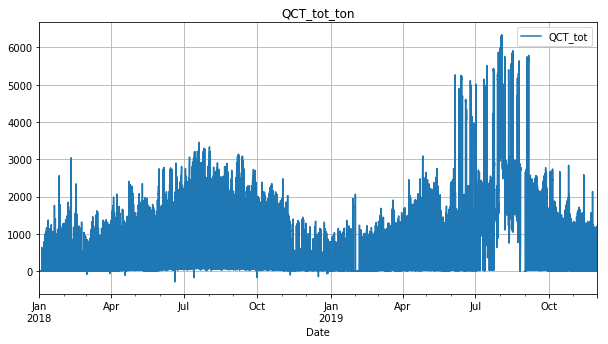

In [7]:
#%% cooling tower capacity [kW]
dum=DataFrame()
dum['TCWS']=TCWS.mean(axis=1).apply(f2c)
dum['TCWR']=TCWR.mean(axis=1).apply(f2c)
dum['mCW']=mCW['mcwsum']
QCT_tot=dum['mCW']*4.2*(dum['TCWR']-dum['TCWS'])
QCT_tot=QCT_tot.to_frame('QCT_tot')

figure(figsize=(10,5))
ax=subplot(111)
QCT_tot.apply(kW2ton).plot(ax=ax,grid=True)
title('QCT_tot_ton')
DATA=DATA.merge(QCT_tot,how='outer',on='Date')


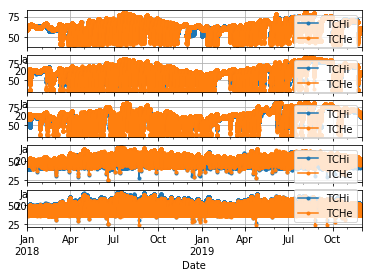

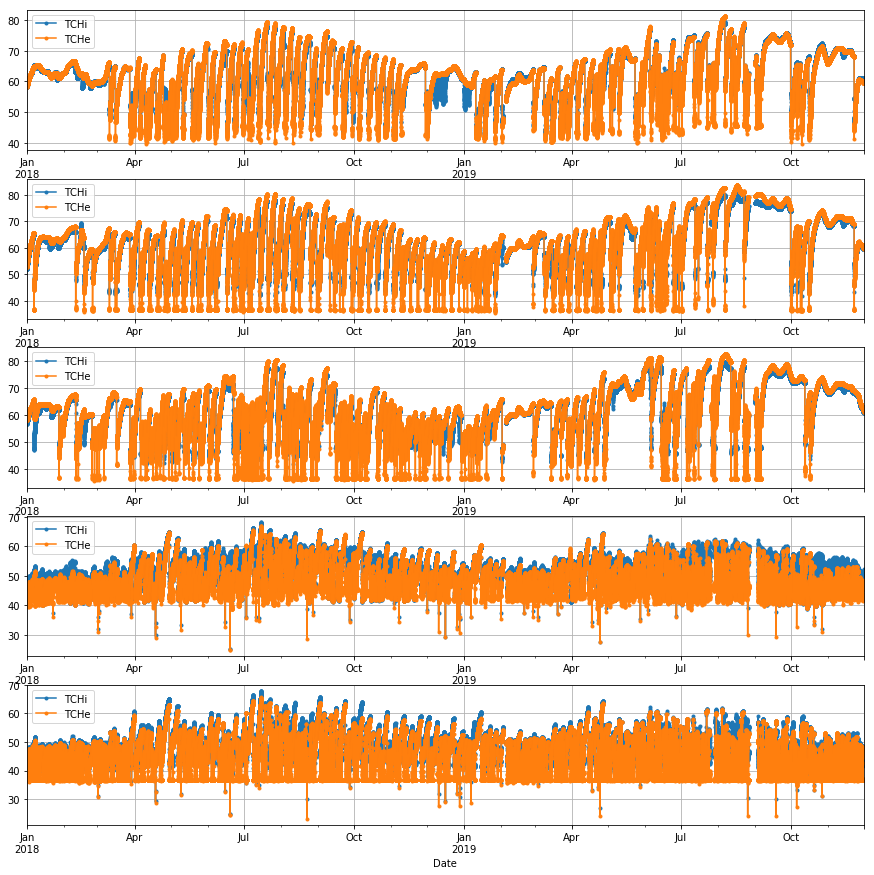

In [8]:
#%% TCHWS & R , 4 is opposite
TCHi=data['TCHi'][startdate:enddate].resample('15T').mean()
TCHe=data['TCHe'][startdate:enddate].resample('15T').mean()
figure()
for i in range(1,6):
    ax=subplot(5,1,i)
    TCHi[enum('TCHi',i)].plot(ax=ax,style='.-')
    TCHe[enum('TCHe',i)].plot(ax=ax,style='.-')
    legend(['TCHi','TCHe'])
    grid(True)
#% rename data
TCHW=TCHi.merge(TCHe,on='Date')
TCHi=DataFrame()
TCHe=DataFrame()

for i in range(1,6):
    if i!=4: 
        TCHi[str(i)]=TCHW[enum('TCHi',i)]
        TCHe[str(i)]=TCHW[enum('TCHe',i)]
    else:
        TCHi[str(i)]=TCHW[enum('TCHe',i)]
        TCHe[str(i)]=TCHW[enum('TCHi',i)]    
figure(figsize=(15,15))
ax=subplot(111)
for i in range(1,6):
    ax=subplot(5,1,i)
    TCHi[str(i)].plot(ax=ax,style='.-')
    TCHe[str(i)].plot(ax=ax,style='.-')
    legend(['TCHi','TCHe'])
    grid(True)


renamedTCHi=TCHi.copy()
renamedTCHe=TCHe.copy()
renamedTCHi.columns=['TCHi'+str(k+1) for k in range(5)]
renamedTCHe.columns=['TCHe'+str(k+1) for k in range(5)]
DATA=DATA.merge(renamedTCHi,how='outer',on='Date')
DATA=DATA.merge(renamedTCHe,how='outer',on='Date')

/home/adun6414/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/adun6414/Downloads/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


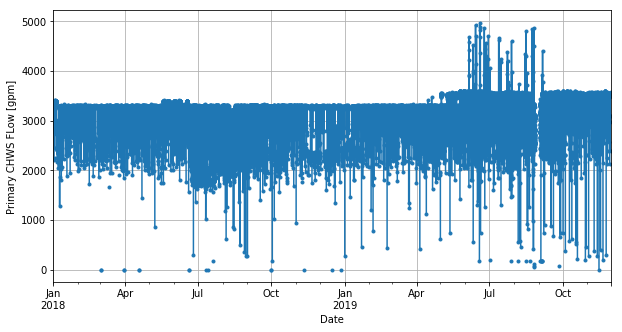

<Figure size 432x288 with 0 Axes>

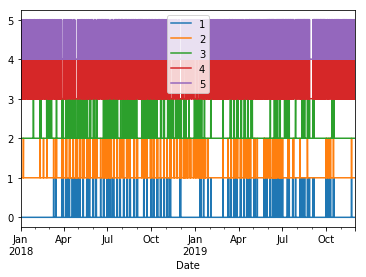

In [9]:
#%% mass flow rate 
# close('all')
dd=data['TCHS_n_TCHR'][startdate:enddate].resample('15T').mean()
TCHWSR=dd[['Chilled Water Supply','Chilled Water Return']]
mflow=dd[['CHW Flow (gpm)',
       u'CHW Total Sec GPM', 
       u'Primary CHWR Temp', 
       u'Primary CHWS Flow To TES',
       u'Primary CHWS Flow']]
# distribution of mflow when the  flow is over than 5000 gpm
mCH_tot=mflow['Primary CHWS Flow'] #gpm
mCH_tot[mCH_tot>5000]=0.5*mCH_tot[mCH_tot>5000]   
mCH_tot=mCH_tot.apply(gpm2kgs).to_frame()
mCH_totON=mCH_tot.merge(ON,on='Date')


figure(figsize=(10,5))
ax=subplot(111)
mflow['Primary CHWS Flow'].plot(style='.-',ax=ax,grid=True);ylabel('Primary CHWS FLow [gpm]')

if wannasave:
    savefig('data_mgpm.png') 
#check flow is consistent with power on off
figure()
ONPLOT.plot()
#(mCH_tot/max(mCH_tot.dropna())*6).plot()

DATA=DATA.merge(TCHWSR,how='outer',on='Date')
DATA=DATA.merge(mflow,how='outer',on='Date')
renamed_mCH_tot=mCH_tot.copy()
renamed_mCH_tot.columns=['mCH_tot']
DATA=DATA.merge(renamed_mCH_tot,how='outer',on='Date')

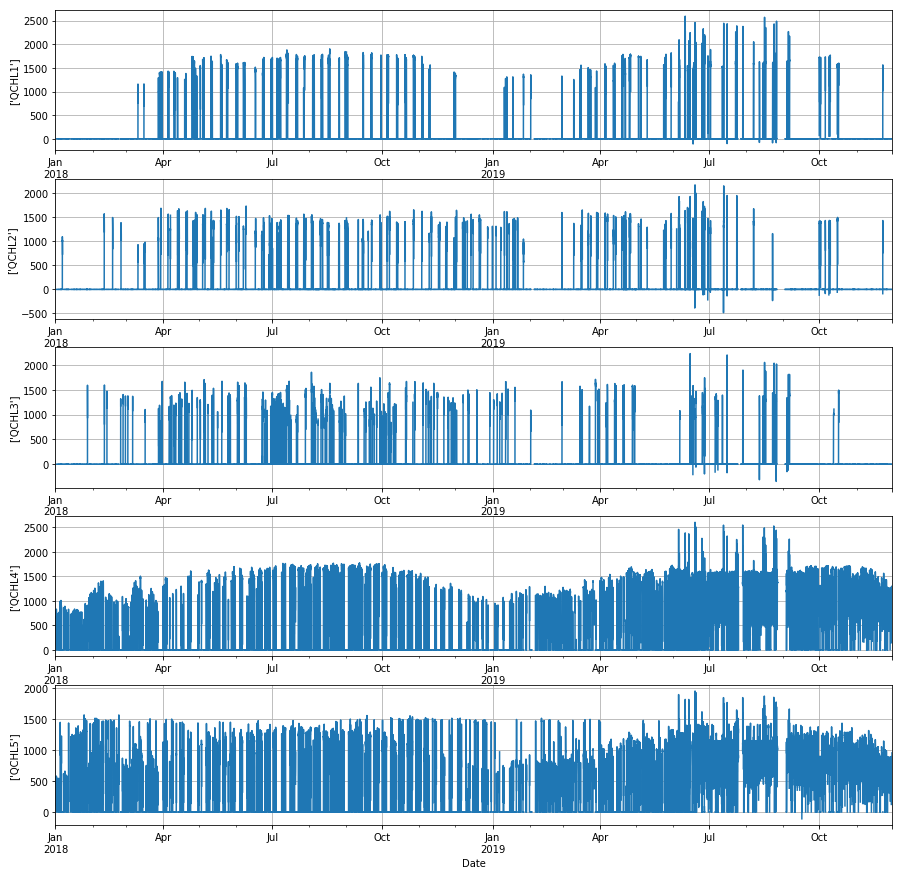

In [10]:
#%% split mCHtotal to each mCH

for i in range(1,6):
    mCH_totON[str(i)]=multiply(mCH_totON[str(i)],mCH_totON['Primary CHWS Flow'])    

Qhat=DataFrame()
for i in range(1,6):
    Qhat[str(i)]=multiply(4.2*mCH_totON[str(i)], TCHi[str(i)].apply(f2c)-TCHe[str(i)].apply(f2c))
figure(figsize=(15,15))
for i in range(1,6):
    ax=subplot(5,1,i)
    Qhat[str(i)].apply(kW2ton).plot(ax=ax,grid=True)
    ylabel(['QCHL'+str(i)])
    #QCHLkW[enum('Q',i)].plot(ax=ax,style='r')

if wannasave:
    savefig('data_QkW.png') 
    
renamedQhat=Qhat.copy()
renamedQhat.columns=['QCHL'+str(k+1) for k in range(5)]
renamedQhat['QCHLsum']=renamedQhat.sum(axis=1)
DATA=DATA.merge(renamedQhat,how='outer',on='Date')
#Qhat=mCH*4.2*(TCHi-TCHe)
#Rawdata_CH={'index':mCH_totON.index,'mCH_totON':mCH_totON.to_numpy(), 'Qhat':Qhat.to_numpy(), 'PkWiCH':PkWiCH.to_numpy(),'TCHe':TCHe.to_numpy(),'TCHi':TCHi.to_numpy(),'TCWS':TCWS.to_numpy(),'TCWR':TCWR.to_numpy()}
#sp.io.savemat('Rawdata_CH',Rawdata_CH)

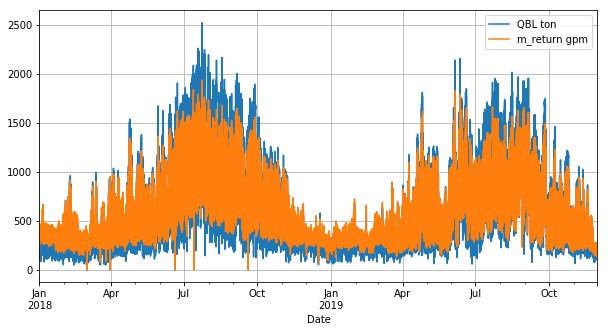

In [11]:
#%% building load plot
# delta T ? plot(TCHWSR['Chilled Water Return'].apply(f2c)-TCHWSR['Chilled Water Supply'].apply(f2c))
Cp=4.2;
mrgpm=mflow['CHW Total Sec GPM']
mr=mrgpm.apply(gpm2kgs).to_frame('mr')
QBLton=(mflow['CHW Total Sec GPM'].apply(gpm2kgs)*Cp*(TCHWSR['Chilled Water Return'].apply(f2c)-TCHWSR['Chilled Water Supply'].apply(f2c))).apply(kW2ton)
QBL=QBLton.apply(ton2kW).to_frame('QBL')
figure(figsize=(10,5))
ax=subplot(111)
QBLton.plot(ax=ax)
mrgpm.plot(ax=ax)
grid(True)
legend(['QBL ton','m_return gpm'])

DATA=DATA.merge(mr,how='outer',on='Date')
DATA=DATA.merge(QBL,how='outer',on='Date')

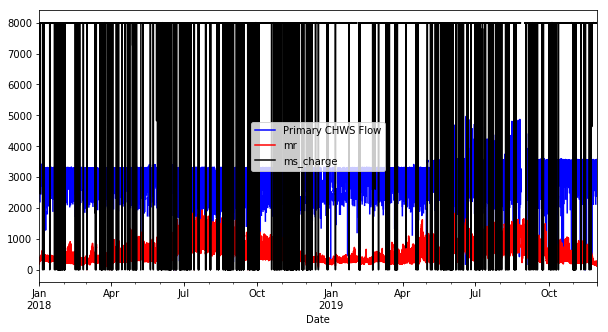

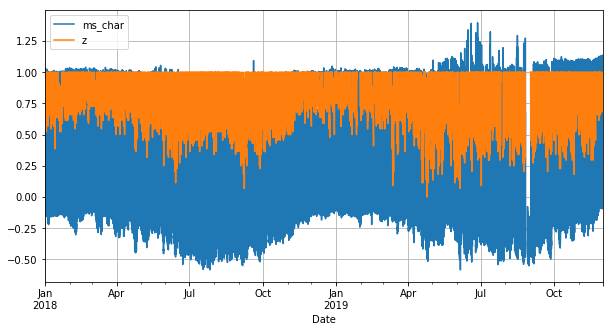

In [12]:
#%% storage data
ms_charge=mflow['Primary CHWS Flow To TES'].apply(gpm2kgs).to_frame('ms_charge')
z=data['z'][startdate:enddate].resample('15T').mean()
z.columns=['z']
#% mass balance ms_charge doesn't make any sense!!!
figure(figsize=(10,5))
ax=subplot(111)
mCH_tot.apply(kgs2gpm).plot(ax=ax,style='b')
mr.apply(kgs2gpm).plot(ax=ax,style='r')
ms_charge.apply(kgs2gpm).plot(ax=ax,style='k')

mCH_tot=mCH_tot.fillna(value=0)
ms_charge_hat=subtract(mCH_tot,mr)
ms_charge_hat.columns=['ms_char']

figure(figsize=(10,5))
ax=subplot(111)
(ms_charge_hat.apply(kgs2gpm)/3000).plot(ax=ax)
(0.01*z).plot(ax=ax)
grid(True)
if wannasave:
    savefig('z_mflow.png')
#data['mCH_n_mr'].plot()


DATA=DATA.merge(ms_charge_hat,how='outer',on='Date')
DATA=DATA.merge(z,how='outer',on='Date')

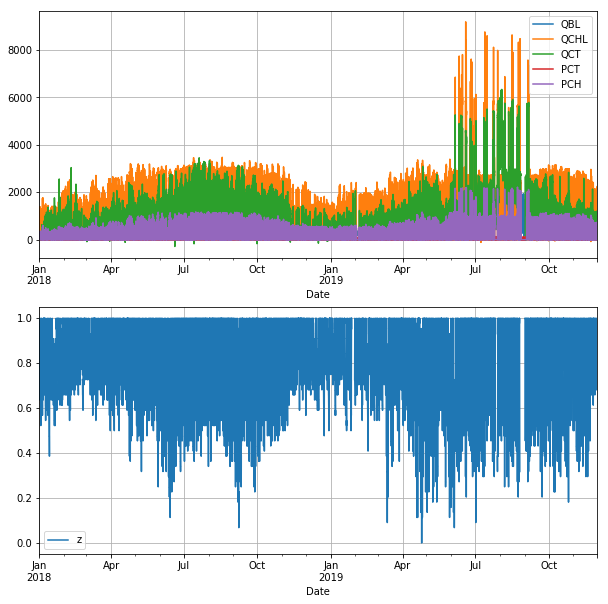

In [13]:
#%% storage temperatre
T1=data['Ts1328'][startdate:enddate].resample('15T').mean()
T2=data['Ts2944'][startdate:enddate].resample('15T').mean()
Ts=T1.merge(T2,on='Date',how='inner')
T3=data['Ts4556'][startdate:enddate].resample('15T').mean()
Ts=Ts.merge(T3,on='Date',how='inner')

#%
figure(figsize=(10,10))
ax=subplot(211)
QBLton.plot(ax=ax)
Qhat.sum(axis=1).apply(kW2ton).plot(ax=ax)
QCT_tot.apply(kW2ton).plot(ax=ax)
PCTtot.plot(ax=ax)
PCH['PCHsum'].plot(ax=ax)
grid(True)
legend(['QBL','QCHL','QCT','PCT','PCH'])

ax=subplot(212)
(0.01*z).plot(ax=ax)
grid(True)
if wannasave:
    savefig('Final.png')
DATA=DATA.merge(Ts,how='outer',on='Date')

In [14]:
#DATA.to_csv('DATA'+str(Timestamp(startdate).month)+'to'+str(Timestamp(enddate).month)+'.csv',header=True)

## From here, secondary flow estimation
##  Find chiller inlet and outlet temperatures only for active chillers.

In [73]:
TCHim=TCHi[ON>0].mean(axis=1,numeric_only=True).to_frame().apply(f2c) # chiller inlet temp when flows
TCHem=TCHe[ON>0].mean(axis=1,numeric_only=True).to_frame().apply(f2c) # chiller outlet temp when flows


#TCHi[ON>0].mean(axis=1,numeric_only=True)['2019-08-01':'2019-08-07'].plot()
#TCHe[ON>0].mean(axis=1,numeric_only=True)['2019-08-01':'2019-08-07'].plot()
TCHWR=TCHWSR['Chilled Water Return'].apply(f2c).to_frame()
TCHWS=TCHWSR['Chilled Water Supply'].apply(f2c).to_frame()
TSH=Ts['TT-13 Temp'].apply(f2c).to_frame()
TSC=Ts['TT-56 Temp'].apply(f2c).to_frame()

# variables
# TCHim [C]: Chiller inlet temperature only for active chillers (Nan for deactivate chillers)
# TCHem [C]: Chiller exit temperature only for active chillers (Nan for deactivate chillers)
# mCH_tot [kg/s]: water flow rate that goes to chillers from 'Primary CHWS Flow'
# mr [kg/s]: return water flow rate that goes to building from 'CHW Total Sec GPM'
# TCHWS [C]: Chilled water supply 
# TCHWS [C]: Chilled water return
# TsH [C]: Hot(warm) water temperature connected at the discharging port of the storage (assumed the top)
# TsC [C]: cold water temperature  connected at the charing port of the storage (assumed the bottom)
# ms_charge=mflow['Primary CHWS Flow To TES']


## issue 1: What are the temp node numbers at charing and discharging ports
## issue 2: For discharging perods, there are no ways of estimating secondary flow 
- 1) because the chiller is off
-  2) because the merging temperatures are very close each other

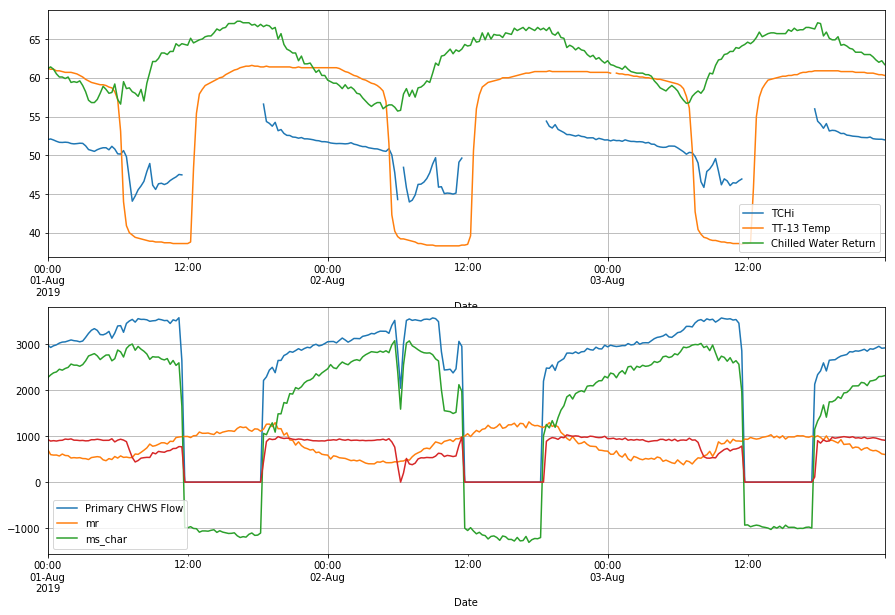

In [75]:
# charging period tempature
figure(figsize=(15,10))
ax=subplot(211)
TCHim.columns=['TCHi']
TCHim['2019-08-01':'2019-08-3'].apply(c2f).plot(ax=ax)
TSH['2019-08-01':'2019-08-3'].apply(c2f).plot(ax=ax)
TCHWR['2019-08-01':'2019-08-3'].apply(c2f).plot(ax=ax,grid=True)

ax=subplot(212)
mCH_tot['2019-08-01':'2019-08-3'].apply(kgs2gpm).plot(ax=ax)
mr['2019-08-01':'2019-08-3'].apply(kgs2gpm).plot(ax=ax)
#ms_charge['2019-08-01':'2019-08-3'].apply(kgs2gpm).plot(ax=ax)
ms_charge_hat['2019-08-01':'2019-08-3'].apply(kgs2gpm).plot(ax=ax,grid=True)

PCH['PCHsum']['2019-08-01':'2019-08-3'].plot(ax=ax,grid=True)